In [1]:
import os
import torch
import numpy as np
import polars as pl
from model_vae import *
from data_preparation import *
from plotting import *
from postprocess import *

In [2]:
final_data = pl.read_parquet("data/colorado_prepared.parquet")

# Prepare data for the VAE model
save_dir = "intermediates"
load_data = True
save_data = False

if load_data:
    input_data, target_indices, participation_mask_tensor, num_candidates_per_contest, metadata = load_prepared_data(save_dir)
else:
    input_data, target_indices, participation_mask_tensor, num_candidates_per_contest, metadata = load_and_prepare_voter_data(final_data)
    
    if save_data: save_prepared_data(save_dir, (input_data, target_indices, participation_mask_tensor, num_candidates_per_contest, metadata))


# Create and train the model
# Model parameters
hidden_dim = 64
latent_dim = 2
num_epochs = 30
batch_size = 256
learning_rate = 1e-3

pres_race_name = "US PRESIDENT_FEDERAL"
trump_name = "DONALD J TRUMP"
biden_name = "JOSEPH R BIDEN"

model = VoterChoiceVAE(
    num_contests=len(num_candidates_per_contest),
    num_candidates_per_contest=num_candidates_per_contest,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim
)
model = model.to(get_device())

In [3]:
# Save only the model parameters
load_model = True

if load_model:
    model.load_state_dict(torch.load('models/vae_sample2000_noCollapse.pt', weights_only=True, map_location=torch.device('cpu')))
else:
    # Train with constraint
    soft_model = train_voter_vae_constrained(
        model, 
        input_data, 
        target_indices,
        participation_mask_tensor,
        metadata, 
        pres_race_name, 
        trump_name, 
        biden_name,
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        kl_start_weight=0,
        kl_end_weight=0.5,
        kl_annealing='sigmoid',
        constraint_weight=1
    )

    # Apply post-processing to ensure consistent orientation of all latent dimensions
    soft_model = post_process_latent_space(soft_model, metadata, pres_race_name, trump_name, biden_name)

    torch.save(soft_model.state_dict(), 'models/vae_adams.pt')


In [7]:
with torch.no_grad():
    # Direct variance from encoder
    voter_variances, avg_uncertainties = model.get_direct_variance(input_data, participation_mask_tensor)
    
    # MC dropout variance (runs multiple forward passes with dropout enabled)
    mc_variances, mc_avg_uncertainties = model.get_mc_dropout_variance(input_data, participation_mask_tensor)
    
    # ELBO-based uncertainty
    kl_uncertainties = model.get_elbo_uncertainty(input_data, participation_mask_tensor)

most_uncertain_voters = torch.argsort(avg_uncertainties, descending=True)[:10]
least_uncertain_voters = torch.argsort(avg_uncertainties)[:10]


In [29]:
pd.options.display.max_rows = 100

# Map indices to voter IDs
most_uncertain_voter_ids = [metadata['idx_to_voter_id'][idx.item()] for idx in most_uncertain_voters]

# Filter final_data for rows with voter IDs in most_uncertain_voter_ids
most_uncertain_voter_data = final_data.filter(pl.col("cvr_id") == "YUMA_1428")

# most_uncertain_voter_ids
most_uncertain_voter_data

with pl.Config(tbl_rows=1000):
    print(most_uncertain_voter_data)

shape: (23, 5)
┌─────────────┬───────────┬─────────────────────┬───────────────────────────┬────────────────┐
│ county_name ┆ cvr_id    ┆ office              ┆ district                  ┆ candidate      │
│ ---         ┆ ---       ┆ ---                 ┆ ---                       ┆ ---            │
│ str         ┆ str       ┆ str                 ┆ str                       ┆ str            │
╞═════════════╪═══════════╪═════════════════════╪═══════════════════════════╪════════════════╡
│ YUMA        ┆ YUMA_1428 ┆ US PRESIDENT        ┆ FEDERAL                   ┆ DONALD J TRUMP │
│ YUMA        ┆ YUMA_1428 ┆ US SENATE           ┆ COLORADO                  ┆ CORY GARDNER   │
│ YUMA        ┆ YUMA_1428 ┆ US HOUSE            ┆ 004                       ┆ KEN BUCK       │
│ YUMA        ┆ YUMA_1428 ┆ COUNTY COMMISSIONER ┆ YUMA 2                    ┆ SCOTT WEAVER   │
│ YUMA        ┆ YUMA_1428 ┆ COUNTY COMMISSIONER ┆ YUMA 3                    ┆ ROBIN J WILEY  │
│ YUMA        ┆ YUMA_1428 ┆ SUPREME

In [ ]:
# Generate and analyze embeddings
print("\nGenerating voter embeddings...")
# voter_embeddings_df = analyze_voter_embeddings(model, input_data, participation_mask_tensor, metadata)

# Extract IRT parameters
print("\nExtracting IRT-equivalent parameters...")
discrimination_params, difficulty_params = model.get_irt_parameters()

# Convert to more interpretable format
print("\nSample of discrimination parameters for the president:")
first_contest = list(metadata['race_to_idx'].keys())[-2]
first_contest_idx = metadata['race_to_idx'][first_contest]
first_contest_discrimination = discrimination_params[first_contest_idx].numpy()

print(f"Contest: {first_contest}")
for i, candidate in enumerate(metadata['candidate_maps'][first_contest_idx].keys()):
    print(f"  Candidate: {candidate}")
    print(f"    Discrimination parameters: {first_contest_discrimination[i]}")

In [ ]:
office_idx = metadata["race_to_idx"]["US PRESIDENT_FEDERAL"]
biden_idx = metadata["candidate_maps"][office_idx]["JOSEPH R BIDEN"]

# Now apply reference candidate post-processing for visualization
adjusted_params, reference_info = process_and_visualize_relative_vectors(
    model, input_data, participation_mask_tensor, metadata, final_data, 
    contest_filter = "US HOUSE_004",
    # reference_candidates = {office_idx: biden_idx}, contest_filter = ["US PRESIDENT"]
)

In [ ]:
visualize_voter_latent_space(
    model, input_data, participation_mask_tensor, 
    metadata, final_data, pres_race_name, trump_name, biden_name
)

In [4]:
discrim_uncertainty, diff_uncertainty = model.get_parameter_uncertainty(input_data, participation_mask_tensor)

discrim_uncertainty

[tensor([[0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         

[[0. 0.]
 [0. 0.]]
range(0, 2)
[[ 0.82698613 -0.35984585]
 [-0.6251621  -1.187878  ]]


ValueError: too many values to unpack (expected 1)

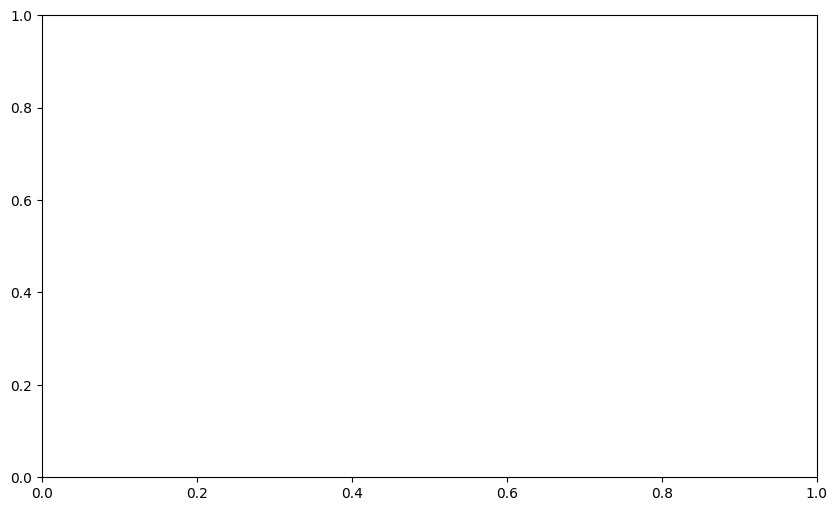

In [ ]:
# Get uncertainty estimates
discrim_uncertainty, diff_uncertainty = model.get_parameter_uncertainty(input_data, participation_mask_tensor)

# Plot parameters with uncertainty
import matplotlib.pyplot as plt

def plot_with_uncertainty(params, uncertainties, param_names=None):
    for contest_idx, (param, uncertainty) in enumerate(zip(params, uncertainties)):
        plt.figure(figsize=(10, 6))
        
        # Convert to numpy for plotting
        param_values = param.cpu().numpy()
        uncertainty_values = uncertainty.cpu().numpy()

        print(uncertainty_values)
        
        # Plot with error bars
        x = range(len(param_values))
        
        print(x)
        print(param_values)

        plt.errorbar(x=x, y=param_values)
        
        if param_names:
            plt.xticks(x, param_names[contest_idx], rotation=45)
            
        # plt.title(f"{title} - Contest {contest_idx}")
        plt.tight_layout()
        plt.show()

# Get parameters
discrimination_params, difficulty_params = model.get_irt_parameters()

# Plot
plot_with_uncertainty(discrimination_params, discrim_uncertainty)
plot_with_uncertainty(difficulty_params, diff_uncertainty, title="Difficulty Parameters")

In [30]:
office_idx = metadata["race_to_idx"]["US SENATE_COLORADO"]
candidate_idx = metadata["candidate_maps"][office_idx]["JOHN W HICKENLOOPER"]

visualize_dimensions_as_points(
        model, 
        metadata,
        reference_candidates = {office_idx: candidate_idx},
        contest_filter="US HOUSE",
        plot_reference=True
    )

TypeError: visualize_dimensions_as_points() got an unexpected keyword argument 'reference_candidates'

## Archive

In [ ]:
create_latent_space_visualizations(
    soft_model, input_data, participation_mask_tensor, metadata,
    final_data, num_candidates_per_contest, pres_race_name, trump_name, biden_name
)

In [ ]:
# base_data_pl = pl.read_parquet("../cvrs/data/pass2/state=COLORADO/county_name=ADAMS/", columns = ["state", "county_name", "cvr_id", "candidate", "district", "magnitude", "office", "party_detailed"])

base = pl.scan_parquet("../cvrs/data/pass2/state=COLORADO").with_columns((pl.col('office') + '_' + pl.col('district')).alias('race'))

data_subset = pl.scan_parquet("adams_subset.parquet").with_columns(pl.lit("ADAMS").alias('county_name'))

# drop uncontested elections
small_candidates = (base
    .filter(pl.col("candidate") != "UNDERVOTE")
    .group_by(['race', 'candidate'])
    .agg(pl.len().alias('n'))
    .filter(pl.col('n') <= 20)
    .select(['race', 'candidate'])
    .unique())

# Equivalent of anti_join and subsequent operations
contested_races = (base
    .filter(pl.col("candidate") != "UNDERVOTE")
    # Anti-join equivalent: keep only rows where (race, candidate) is not in small_candidates
    .join(small_candidates, on=['race', 'candidate'], how='anti')
    .select(['race', 'candidate'])
    .unique()
    .group_by('race')
    .agg(pl.len().alias('n'))
    .filter(pl.col('n') > 1)
    .select('race'))

# Rejoin with original data to get all records for these individuals
final_data = (
    base
    .with_columns(pl.col('cvr_id').cast(pl.Utf8))
    .join(
        contested_races,
        on=['race'],
        how="inner"
    )
    .join(
        data_subset.select(['county_name', "cvr_id"]),
        on=["county_name", "cvr_id"],
        how="inner"
    )
    .select(
        ["county_name", "cvr_id", "office", "district", "candidate"]
     )
    .filter(
        pl.col("candidate") != "UNDERVOTE"
    )
    .collect()
    .to_pandas()
)

final_data